In [59]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from torchviz import make_dot
from torchsummary import summary
import torchvision.transforms.functional as TF
from utils import pytorchtools

In [61]:
torch.cuda.empty_cache()

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Parameters

In [63]:
input_size = 784
num_classes = 10
num_epochs = 1000
patience = 10
batch_size = 512
learning_rate = 0.001

### MNIST dataset 

In [64]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

In [65]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

In [66]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=transform)

In [67]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Fully connected neural network

In [68]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        #layers
        self.l1 = nn.Linear(784, 100) # layer 1
        self.l2 = nn.Linear(100, 50) # layer 2
        self.l3 = nn.Linear(50, 10) # layer 3
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)

        
        return x

In [69]:
model = NeuralNet().to(device)

### Loss and optimizer

In [70]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

### Architecture

In [71]:
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 50]           5,050
              ReLU-4                [-1, 1, 50]               0
            Linear-5                [-1, 1, 10]             510
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


### Train the model

In [72]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [73]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
#         images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
#         print(images.shape)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        
        #calculate train_loss
        train_losses.append(loss.item())
        optimizer.step()
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = numpy.average(train_losses)
    valid_loss = numpy.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

60000
train_loss: 2.29867 valid_loss: 2.28789
Validation loss decreased (inf --> 2.287889).  Saving model ...
0
train_loss: 2.27870 valid_loss: 2.26880
Validation loss decreased (2.287889 --> 2.268797).  Saving model ...
1
train_loss: 2.26036 valid_loss: 2.24943
Validation loss decreased (2.268797 --> 2.249432).  Saving model ...
2
train_loss: 2.24067 valid_loss: 2.22818
Validation loss decreased (2.249432 --> 2.228184).  Saving model ...
3
train_loss: 2.21908 valid_loss: 2.20510
Validation loss decreased (2.228184 --> 2.205098).  Saving model ...
4
train_loss: 2.19562 valid_loss: 2.17991
Validation loss decreased (2.205098 --> 2.179907).  Saving model ...
5
train_loss: 2.16986 valid_loss: 2.15261
Validation loss decreased (2.179907 --> 2.152606).  Saving model ...
6
train_loss: 2.14198 valid_loss: 2.12260
Validation loss decreased (2.152606 --> 2.122602).  Saving model ...
7
train_loss: 2.11061 valid_loss: 2.08867
Validation loss decreased (2.122602 --> 2.088671).  Saving model ...
8


train_loss: 0.45610 valid_loss: 0.44087
Validation loss decreased (0.444285 --> 0.440869).  Saving model ...
74
train_loss: 0.45365 valid_loss: 0.43804
Validation loss decreased (0.440869 --> 0.438041).  Saving model ...
75
train_loss: 0.45179 valid_loss: 0.43515
Validation loss decreased (0.438041 --> 0.435146).  Saving model ...
76
train_loss: 0.44758 valid_loss: 0.43225
Validation loss decreased (0.435146 --> 0.432246).  Saving model ...
77
train_loss: 0.44465 valid_loss: 0.42960
Validation loss decreased (0.432246 --> 0.429596).  Saving model ...
78
train_loss: 0.44130 valid_loss: 0.42644
Validation loss decreased (0.429596 --> 0.426442).  Saving model ...
79
train_loss: 0.43927 valid_loss: 0.42377
Validation loss decreased (0.426442 --> 0.423767).  Saving model ...
80
train_loss: 0.43710 valid_loss: 0.42140
Validation loss decreased (0.423767 --> 0.421396).  Saving model ...
81
train_loss: 0.43309 valid_loss: 0.41884
Validation loss decreased (0.421396 --> 0.418841).  Saving model

train_loss: 0.34544 valid_loss: 0.33544
Validation loss decreased (0.336238 --> 0.335443).  Saving model ...
147
train_loss: 0.34412 valid_loss: 0.33460
Validation loss decreased (0.335443 --> 0.334604).  Saving model ...
148
train_loss: 0.34288 valid_loss: 0.33385
Validation loss decreased (0.334604 --> 0.333854).  Saving model ...
149
train_loss: 0.34273 valid_loss: 0.33346
Validation loss decreased (0.333854 --> 0.333465).  Saving model ...
150
train_loss: 0.34219 valid_loss: 0.33260
Validation loss decreased (0.333465 --> 0.332599).  Saving model ...
151
train_loss: 0.34099 valid_loss: 0.33206
Validation loss decreased (0.332599 --> 0.332057).  Saving model ...
152
train_loss: 0.33985 valid_loss: 0.33150
Validation loss decreased (0.332057 --> 0.331499).  Saving model ...
153
train_loss: 0.33944 valid_loss: 0.33080
Validation loss decreased (0.331499 --> 0.330797).  Saving model ...
154
train_loss: 0.33825 valid_loss: 0.33012
Validation loss decreased (0.330797 --> 0.330118).  Savi

train_loss: 0.30307 valid_loss: 0.29678
Validation loss decreased (0.297307 --> 0.296781).  Saving model ...
220
train_loss: 0.30257 valid_loss: 0.29639
Validation loss decreased (0.296781 --> 0.296393).  Saving model ...
221
train_loss: 0.30419 valid_loss: 0.29573
Validation loss decreased (0.296393 --> 0.295733).  Saving model ...
222
train_loss: 0.30134 valid_loss: 0.29582
EarlyStopping counter: 1 out of 10
223
train_loss: 0.30216 valid_loss: 0.29544
Validation loss decreased (0.295733 --> 0.295444).  Saving model ...
224
train_loss: 0.30119 valid_loss: 0.29484
Validation loss decreased (0.295444 --> 0.294842).  Saving model ...
225
train_loss: 0.29996 valid_loss: 0.29444
Validation loss decreased (0.294842 --> 0.294444).  Saving model ...
226
train_loss: 0.30116 valid_loss: 0.29416
Validation loss decreased (0.294444 --> 0.294155).  Saving model ...
227
train_loss: 0.29993 valid_loss: 0.29372
Validation loss decreased (0.294155 --> 0.293715).  Saving model ...
228
train_loss: 0.299

train_loss: 0.27414 valid_loss: 0.27140
Validation loss decreased (0.271766 --> 0.271397).  Saving model ...
294
train_loss: 0.27401 valid_loss: 0.27111
Validation loss decreased (0.271397 --> 0.271114).  Saving model ...
295
train_loss: 0.27398 valid_loss: 0.27077
Validation loss decreased (0.271114 --> 0.270769).  Saving model ...
296
train_loss: 0.27345 valid_loss: 0.27040
Validation loss decreased (0.270769 --> 0.270403).  Saving model ...
297
train_loss: 0.27313 valid_loss: 0.27025
Validation loss decreased (0.270403 --> 0.270246).  Saving model ...
298
train_loss: 0.27289 valid_loss: 0.26986
Validation loss decreased (0.270246 --> 0.269856).  Saving model ...
299
train_loss: 0.27245 valid_loss: 0.26973
Validation loss decreased (0.269856 --> 0.269731).  Saving model ...
300
train_loss: 0.27283 valid_loss: 0.26932
Validation loss decreased (0.269731 --> 0.269323).  Saving model ...
301
train_loss: 0.27256 valid_loss: 0.26909
Validation loss decreased (0.269323 --> 0.269091).  Savi

train_loss: 0.25305 valid_loss: 0.25126
Validation loss decreased (0.251545 --> 0.251263).  Saving model ...
368
train_loss: 0.25203 valid_loss: 0.25094
Validation loss decreased (0.251263 --> 0.250936).  Saving model ...
369
train_loss: 0.25130 valid_loss: 0.25066
Validation loss decreased (0.250936 --> 0.250657).  Saving model ...
370
train_loss: 0.25238 valid_loss: 0.25048
Validation loss decreased (0.250657 --> 0.250484).  Saving model ...
371
train_loss: 0.25112 valid_loss: 0.25010
Validation loss decreased (0.250484 --> 0.250101).  Saving model ...
372
train_loss: 0.25033 valid_loss: 0.24972
Validation loss decreased (0.250101 --> 0.249718).  Saving model ...
373
train_loss: 0.25056 valid_loss: 0.24949
Validation loss decreased (0.249718 --> 0.249489).  Saving model ...
374
train_loss: 0.24981 valid_loss: 0.24929
Validation loss decreased (0.249489 --> 0.249291).  Saving model ...
375
train_loss: 0.24940 valid_loss: 0.24905
Validation loss decreased (0.249291 --> 0.249054).  Savi

train_loss: 0.23253 valid_loss: 0.23343
Validation loss decreased (0.233562 --> 0.233427).  Saving model ...
442
train_loss: 0.23345 valid_loss: 0.23306
Validation loss decreased (0.233427 --> 0.233056).  Saving model ...
443
train_loss: 0.23181 valid_loss: 0.23313
EarlyStopping counter: 1 out of 10
444
train_loss: 0.23202 valid_loss: 0.23262
Validation loss decreased (0.233056 --> 0.232615).  Saving model ...
445
train_loss: 0.23225 valid_loss: 0.23246
Validation loss decreased (0.232615 --> 0.232458).  Saving model ...
446
train_loss: 0.23204 valid_loss: 0.23234
Validation loss decreased (0.232458 --> 0.232338).  Saving model ...
447
train_loss: 0.23168 valid_loss: 0.23203
Validation loss decreased (0.232338 --> 0.232033).  Saving model ...
448
train_loss: 0.23093 valid_loss: 0.23195
Validation loss decreased (0.232033 --> 0.231948).  Saving model ...
449
train_loss: 0.23096 valid_loss: 0.23163
Validation loss decreased (0.231948 --> 0.231633).  Saving model ...
450
train_loss: 0.229

train_loss: 0.21524 valid_loss: 0.21748
Validation loss decreased (0.217737 --> 0.217484).  Saving model ...
516
train_loss: 0.21466 valid_loss: 0.21737
Validation loss decreased (0.217484 --> 0.217369).  Saving model ...
517
train_loss: 0.21427 valid_loss: 0.21706
Validation loss decreased (0.217369 --> 0.217055).  Saving model ...
518
train_loss: 0.21414 valid_loss: 0.21680
Validation loss decreased (0.217055 --> 0.216804).  Saving model ...
519
train_loss: 0.21375 valid_loss: 0.21667
Validation loss decreased (0.216804 --> 0.216674).  Saving model ...
520
train_loss: 0.21321 valid_loss: 0.21632
Validation loss decreased (0.216674 --> 0.216323).  Saving model ...
521
train_loss: 0.21313 valid_loss: 0.21633
EarlyStopping counter: 1 out of 10
522
train_loss: 0.21307 valid_loss: 0.21582
Validation loss decreased (0.216323 --> 0.215816).  Saving model ...
523
train_loss: 0.21294 valid_loss: 0.21591
EarlyStopping counter: 1 out of 10
524
train_loss: 0.21309 valid_loss: 0.21557
Validation 

train_loss: 0.19842 valid_loss: 0.20284
Validation loss decreased (0.203012 --> 0.202841).  Saving model ...
591
train_loss: 0.19787 valid_loss: 0.20264
Validation loss decreased (0.202841 --> 0.202640).  Saving model ...
592
train_loss: 0.19760 valid_loss: 0.20250
Validation loss decreased (0.202640 --> 0.202505).  Saving model ...
593
train_loss: 0.19662 valid_loss: 0.20232
Validation loss decreased (0.202505 --> 0.202321).  Saving model ...
594
train_loss: 0.19658 valid_loss: 0.20200
Validation loss decreased (0.202321 --> 0.202001).  Saving model ...
595
train_loss: 0.19665 valid_loss: 0.20184
Validation loss decreased (0.202001 --> 0.201837).  Saving model ...
596
train_loss: 0.19701 valid_loss: 0.20177
Validation loss decreased (0.201837 --> 0.201774).  Saving model ...
597
train_loss: 0.19619 valid_loss: 0.20159
Validation loss decreased (0.201774 --> 0.201592).  Saving model ...
598
train_loss: 0.19593 valid_loss: 0.20136
Validation loss decreased (0.201592 --> 0.201360).  Savi

train_loss: 0.18344 valid_loss: 0.18976
Validation loss decreased (0.190029 --> 0.189760).  Saving model ...
667
train_loss: 0.18259 valid_loss: 0.18969
Validation loss decreased (0.189760 --> 0.189688).  Saving model ...
668
train_loss: 0.18319 valid_loss: 0.18948
Validation loss decreased (0.189688 --> 0.189476).  Saving model ...
669
train_loss: 0.18247 valid_loss: 0.18933
Validation loss decreased (0.189476 --> 0.189331).  Saving model ...
670
train_loss: 0.18213 valid_loss: 0.18906
Validation loss decreased (0.189331 --> 0.189061).  Saving model ...
671
train_loss: 0.18293 valid_loss: 0.18889
Validation loss decreased (0.189061 --> 0.188891).  Saving model ...
672
train_loss: 0.18199 valid_loss: 0.18877
Validation loss decreased (0.188891 --> 0.188765).  Saving model ...
673
train_loss: 0.18263 valid_loss: 0.18877
EarlyStopping counter: 1 out of 10
674
train_loss: 0.18172 valid_loss: 0.18865
Validation loss decreased (0.188765 --> 0.188655).  Saving model ...
675
train_loss: 0.181

train_loss: 0.17046 valid_loss: 0.17876
Validation loss decreased (0.178767 --> 0.178756).  Saving model ...
742
train_loss: 0.17027 valid_loss: 0.17845
Validation loss decreased (0.178756 --> 0.178450).  Saving model ...
743
train_loss: 0.17019 valid_loss: 0.17835
Validation loss decreased (0.178450 --> 0.178353).  Saving model ...
744
train_loss: 0.16960 valid_loss: 0.17816
Validation loss decreased (0.178353 --> 0.178159).  Saving model ...
745
train_loss: 0.17166 valid_loss: 0.17813
Validation loss decreased (0.178159 --> 0.178133).  Saving model ...
746
train_loss: 0.16931 valid_loss: 0.17796
Validation loss decreased (0.178133 --> 0.177957).  Saving model ...
747
train_loss: 0.16903 valid_loss: 0.17778
Validation loss decreased (0.177957 --> 0.177778).  Saving model ...
748
train_loss: 0.16892 valid_loss: 0.17775
Validation loss decreased (0.177778 --> 0.177748).  Saving model ...
749
train_loss: 0.16907 valid_loss: 0.17762
Validation loss decreased (0.177748 --> 0.177617).  Savi

train_loss: 0.15868 valid_loss: 0.16879
EarlyStopping counter: 1 out of 10
819
train_loss: 0.15848 valid_loss: 0.16857
Validation loss decreased (0.168755 --> 0.168572).  Saving model ...
820
train_loss: 0.15854 valid_loss: 0.16859
EarlyStopping counter: 1 out of 10
821
train_loss: 0.15887 valid_loss: 0.16840
Validation loss decreased (0.168572 --> 0.168400).  Saving model ...
822
train_loss: 0.15911 valid_loss: 0.16825
Validation loss decreased (0.168400 --> 0.168250).  Saving model ...
823
train_loss: 0.15811 valid_loss: 0.16814
Validation loss decreased (0.168250 --> 0.168144).  Saving model ...
824
train_loss: 0.15763 valid_loss: 0.16816
EarlyStopping counter: 1 out of 10
825
train_loss: 0.15809 valid_loss: 0.16784
Validation loss decreased (0.168144 --> 0.167840).  Saving model ...
826
train_loss: 0.15730 valid_loss: 0.16773
Validation loss decreased (0.167840 --> 0.167728).  Saving model ...
827
train_loss: 0.15843 valid_loss: 0.16784
EarlyStopping counter: 1 out of 10
828
train_

train_loss: 0.14826 valid_loss: 0.16025
Validation loss decreased (0.160326 --> 0.160250).  Saving model ...
896
train_loss: 0.14904 valid_loss: 0.16023
Validation loss decreased (0.160250 --> 0.160230).  Saving model ...
897
train_loss: 0.14840 valid_loss: 0.16009
Validation loss decreased (0.160230 --> 0.160091).  Saving model ...
898
train_loss: 0.14791 valid_loss: 0.15988
Validation loss decreased (0.160091 --> 0.159885).  Saving model ...
899
train_loss: 0.14875 valid_loss: 0.15999
EarlyStopping counter: 1 out of 10
900
train_loss: 0.14865 valid_loss: 0.15969
Validation loss decreased (0.159885 --> 0.159687).  Saving model ...
901
train_loss: 0.14828 valid_loss: 0.15974
EarlyStopping counter: 1 out of 10
902
train_loss: 0.14748 valid_loss: 0.15975
EarlyStopping counter: 2 out of 10
903
train_loss: 0.14744 valid_loss: 0.15948
Validation loss decreased (0.159687 --> 0.159481).  Saving model ...
904
train_loss: 0.14805 valid_loss: 0.15940
Validation loss decreased (0.159481 --> 0.159

train_loss: 0.13912 valid_loss: 0.15291
EarlyStopping counter: 1 out of 10
975
train_loss: 0.13937 valid_loss: 0.15269
Validation loss decreased (0.152812 --> 0.152688).  Saving model ...
976
train_loss: 0.13854 valid_loss: 0.15260
Validation loss decreased (0.152688 --> 0.152602).  Saving model ...
977
train_loss: 0.14001 valid_loss: 0.15230
Validation loss decreased (0.152602 --> 0.152302).  Saving model ...
978
train_loss: 0.13849 valid_loss: 0.15234
EarlyStopping counter: 1 out of 10
979
train_loss: 0.13788 valid_loss: 0.15221
Validation loss decreased (0.152302 --> 0.152212).  Saving model ...
980
train_loss: 0.13818 valid_loss: 0.15213
Validation loss decreased (0.152212 --> 0.152133).  Saving model ...
981
train_loss: 0.13824 valid_loss: 0.15217
EarlyStopping counter: 1 out of 10
982
train_loss: 0.13835 valid_loss: 0.15206
Validation loss decreased (0.152133 --> 0.152061).  Saving model ...
983
train_loss: 0.13776 valid_loss: 0.15188
Validation loss decreased (0.152061 --> 0.151

In [74]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

### Loss function vs Epoch

999


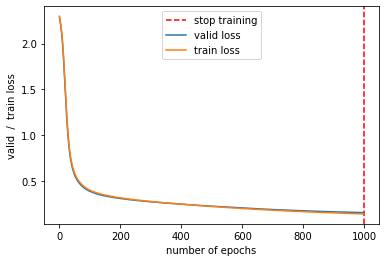

<Figure size 432x288 with 0 Axes>

In [75]:
fig = plt.figure()

######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")

h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)

plt.show()

### Test the model

In [76]:
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'models\\net_custom2.ckpt')

Accuracy of the network on the 10000 test images: 95.57 %


### Building confusion matrix

In [86]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [87]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size =10000)
    train_preds = get_all_preds(model, prediction_loader).to(device)
    
train_preds.shape
train_preds.grad_fn
train_preds.grad

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))
train_preds.is_cuda

total correct 9557
accuracy 0.9557


True

In [88]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)
stacked[9].tolist()
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    j,k = p.tolist()
    cmt[j,k] = cmt[j, k] + 1
    
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [89]:
lb = test_dataset.targets.detach().cpu().numpy()

In [90]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()
print(rp)

[7 2 1 ... 4 5 6]


In [91]:
cm = confusion_matrix(lb, rp)

Confusion matrix, without normalization
[[ 960    0    1    1    0    6    5    3    3    1]
 [   0 1117    2    2    0    1    5    2    6    0]
 [   6    4  981    5    6    1    8    9   11    1]
 [   2    1    8  963    0   14    1   11    7    3]
 [   1    1    6    0  937    0   11    2    3   21]
 [   9    1    1   15    5  839    8    0    7    7]
 [   7    3    2    0    6    9  925    1    5    0]
 [   1    6   20    3    1    1    0  979    1   16]
 [   7    5    4   12    9    7    8    7  912    3]
 [   9    6    1   10   20    4    1    9    5  944]]


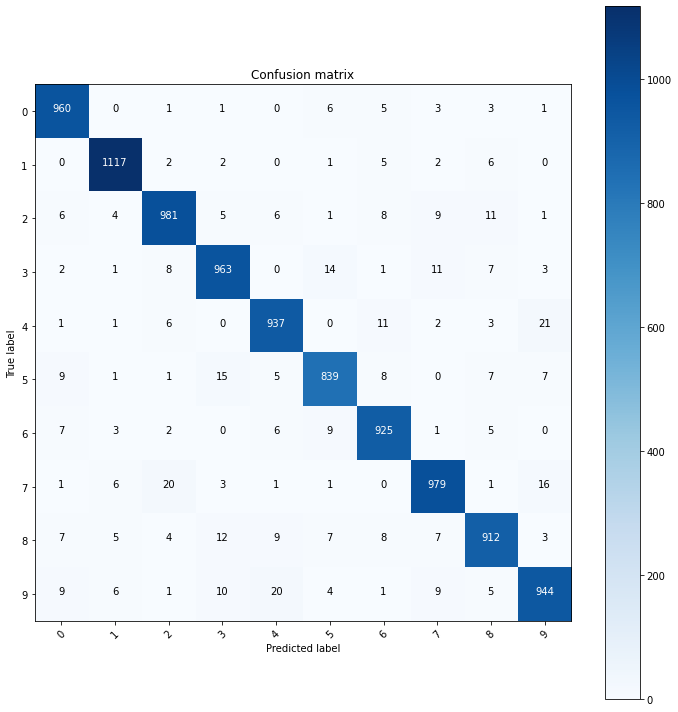

In [92]:
names = set(lb)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

### Image

In [93]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(device)
            data = data.reshape(-1,28*28).to(device)
            output = model(data)
            
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
#                 print(wrong_samples[i].shape)
                sample = sample.reshape(28,28).to(device)
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                path = '.\\mistakes\\net_custom2\\'
                img.save(path+'wrong_idx{}_pred{}_actual{}.png'.format(
                    wrong_idx[i], wrong_pred.item(), actual_pred.item()))

In [94]:
test(model,device, test_loader)